In [1]:
import os
import sys

current_dir =  os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import pyro
from collab import foraging_toolkit as ft
import torch.nn.functional as F
import logging
import time

from scipy.signal import find_peaks

import plotly.io as pio
from plotly import express as px, graph_objects as go, figure_factory as ff
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import (
    AutoNormal,
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_mean,
    init_to_value,
)


from pyro.contrib.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from pyro.optim import Adam
import pyro.optim as optim
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS


In [2]:
ducks_raw = pd.read_csv('../data/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv')
sparrows_raw = pd.read_csv('../data/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv')

display(ducks_raw.head())
display(sparrows_raw.head())

print(ducks_raw.shape)
print(sparrows_raw.shape)

,x,y,time,bird
0,84.853396,22.812170,0,1
1,308.485824,22.659691,0,2
2,75.273170,91.047143,0,12
3,68.939135,99.259521,0,17
4,155.181453,109.061447,0,20


,x,y,time,bird
0,294.843352,82.777842,0,2
1,110.659049,86.254356,0,3
2,6.545799,136.260651,0,11
3,294.693470,83.130834,1,2
4,110.614951,86.297426,1,3


(8867, 4)
(22821, 4)


In [3]:
ducks_sub = ft.subsample_frames_evenly_spaced(ducks_raw, 300)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_obj = ft.object_from_data(ducks_sub, grid_size=90, frames=300,
                                calculate_step_size_max = True)


sps_sub = ft.subsample_frames_evenly_spaced(sparrows_raw)
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_obj = ft.object_from_data(sps_sub, grid_size=90, frames=300,
                              calculate_step_size_max = True)

original_frames: 1450
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1858, 4)
min_time 1
max_time 300
original_frames: 11549
original_shape: (22821, 4)
resulting_frames: 300
resulting_shape: (617, 4)
min_time 1
max_time 300


In [4]:
# these are max shifts along an axis
# sparrows et al. seem more jumpy
print(ducks_obj.step_size_max)
print(sps_obj.step_size_max)


6.0
61.0


In [5]:
#let's get a feel for the distance distribution of ducks
duck_distances = ft.cp_birds_to_bird_distances(ducks_obj)
sps_distances = ft.cp_birds_to_bird_distances(sps_obj)

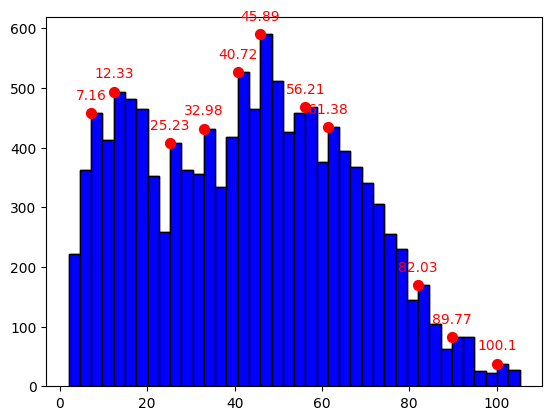

In [6]:
ft.cp_distances_and_peaks(duck_distances)

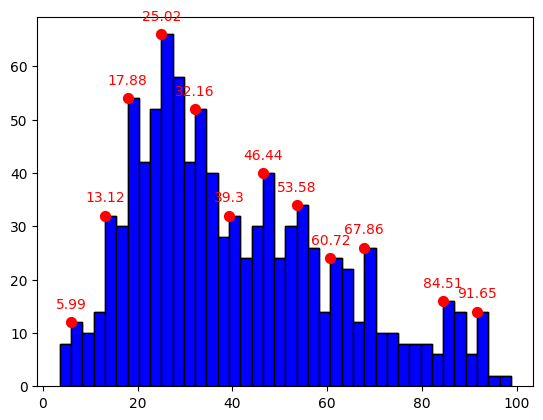

In [7]:
# now sparrows et al.
ft.cp_distances_and_peaks(sps_distances)

# we will use 25, 46, and 85 as proximity hyperparameters
# 25 should work well for sparrows
# 46 should work well for ducks
# 85 should not work well for either

In [8]:
# note were severely subsampling the grid here, mostly for speed

ducks_vis = ft.cp_generate_visibility(ducks_obj.birds, sampling_rate=0.02)
ducks_obj.visibility = ducks_vis["visibility"]
ducks_obj.visibilityDF = ducks_vis["visibilityDF"]

sps_vis = ft.cp_generate_visibility(sps_obj.birds, sampling_rate=0.02)
sps_obj.visibility = sps_vis["visibility"]
sps_obj.visibilityDF = sps_vis["visibilityDF"]

In [9]:
def cp_generate_proximity_score(
    obj,
    visibility_range = 100,
    getting_worse=1.5,
    optimal=4,
    proximity_decay=1,
    start=0,
    end=None,
    time_shift=0,
    joint_df=False,
):
    

    birds = obj.birds
    birdsDF = obj.birdsDF
    
    if end is None:
        end = len(birds[0])
    
    bird_distances = cp_birds_to_bird_distances(obj)

    proximity = obj.visibility.copy()
    

    for bird in range(len(birds)):
        
        times_b = birds[bird]['time'].unique() 
        
        for frame in times_b:
            frame_index = np.where(times_b == frame)[0][0]
            
            birds_at_frameDF = birdsDF[birdsDF['time'] == frame]
            birds_at_frameDF.sort_values(by="bird", inplace=True)
            
            birds_at_frame = birds_at_frameDF['bird'].unique()
            birds_at_frame.sort() # perhaps redundant
            
            assert bird+1 in birds_at_frame
            
            proximity[bird][frame_index]['proximity'] = 0
            
            dist_bt = bird_distances[bird][frame_index]
            
            visible_birds = dist_bt['birds_at_frame'][dist_bt['distance'] <= visibility_range].tolist()
            
            if visible_birds:
                for vb in visible_birds:
                    o_x = birds[vb - 1].loc[birds[vb - 1]['time'] == frame, 'x'].values[0]
                    o_y = birds[vb - 1].loc[birds[vb - 1]['time'] == frame, 'y'].values[0]

                proximity[bird][frame_index]["proximity"] += [
                    ft.proximity_score(s, getting_worse, optimal, proximity_decay)
                    for s in np.sqrt((proximity[bird][frame_index]["x"] - o_x) ** 2 + (proximity[bird][frame_index]["y"] - o_y) ** 2)
                ]

            proximity[bird][frame_index]["proximity_standardized"] = (
                proximity[bird][frame_index]["proximity"] - proximity[bird][frame_index]["proximity"].mean()
            ) / proximity[bird][frame_index]["proximity"].std()

            proximity[bird][frame_index]["proximity_standardized"].fillna(0, inplace=True)

            proximity[bird][frame_index]["bird"] = bird + 1
            proximity[bird][frame_index]["time"] = frame

    proximityDF = pd.concat([pd.concat(p) for p in proximity])

    return {"proximity": proximity, "proximityDF": proximityDF}


prox = cp_generate_proximity_score(
        ducks_obj,
        visibility_range=100,
        getting_worse=2,
        optimal=45,
        proximity_decay=.1,
        time_shift=0,
    )

NameError: name 'cp_birds_to_bird_distances' is not defined

In [25]:
ducks_obj.proximity = prox["proximity"]
ducks_obj.proximityDF = prox["proximityDF"]
display(ducks_obj.proximityDF.head())

,x,y,distance,distance_x,distance_y,visibility,bird,time,proximity,proximity_standardized,how_far_squared,how_far_squared_scaled
6922,77,83,11.747340,5.0,64.0,0.979055,1,116,0.214919,-1.929706,4112.0,0.817017
5993,67,54,7.745967,5.0,35.0,0.990875,1,116,0.929205,0.645593,1261.0,0.943886
7081,79,62,10.000000,7.0,43.0,0.984808,1,116,0.525820,-0.808777,1885.0,0.916118
6143,69,24,2.000000,3.0,5.0,0.999391,1,116,0.932587,0.657786,41.0,0.998176
5844,65,85,10.862780,7.0,66.0,0.982081,1,116,0.464106,-1.031282,4420.0,0.803311


In [26]:
def cp_add_how_far_squared_scaled(sim):
    birds = sim.birds
    step_size_max = sim.step_size_max
    visibility_range = 100
    how_far = sim.proximity.copy() 

    for bird in range(sim.num_birds):
        df = birds[bird]
        for frame in range(len(df) - 1):
            try:
                x_new = int(df["x"][frame + 1])
                y_new = int(df["y"][frame + 1])
            except (KeyError, AttributeError):
                x_new = int(df["x"].iloc[frame + 1])
                y_new = int(df["y"].iloc[frame + 1])
                
            assert isinstance(x_new, int) and isinstance(y_new, int)
            
            
            _hf = how_far[bird][frame]
            _hf["how_far_squared"] = (_hf["x"] - x_new) ** 2 + (
                _hf["y"] - y_new
            ) ** 2
            _hf["how_far_squared_scaled"] = (
                -_hf["how_far_squared"]
                / (2 * (sim.step_size_max + visibility_range) ** 2)
                + 1
            )
  
        #m maybe not needed
        # how_far[bird][len(df)]["how_far_squared"] = np.nan
        # how_far[bbird][len(df)]["how_far_squared_scaled"] = np.nan

    sim.how_far = how_far

    birds_how_far = []
    for bird in range(sim.num_birds):
        birds_how_far.append(pd.concat(how_far[bird]))

    sim.how_farDF = pd.concat(birds_how_far)
    
cp_add_how_far_squared_scaled(ducks_obj)

In [27]:
display(ducks_obj.how_farDF.head())

,x,y,distance,distance_x,distance_y,visibility,bird,time,proximity,proximity_standardized,how_far_squared,how_far_squared_scaled
6922,77,83,11.747340,5.0,64.0,0.979055,1,116,0.214919,-1.929706,4112.0,0.817017
5993,67,54,7.745967,5.0,35.0,0.990875,1,116,0.929205,0.645593,1261.0,0.943886
7081,79,62,10.000000,7.0,43.0,0.984808,1,116,0.525820,-0.808777,1885.0,0.916118
6143,69,24,2.000000,3.0,5.0,0.999391,1,116,0.932587,0.657786,41.0,0.998176
5844,65,85,10.862780,7.0,66.0,0.982081,1,116,0.464106,-1.031282,4420.0,0.803311


In [28]:
def cp_prep_data_for_iference(obj):
    df = obj.how_farDF.copy()
    print("Initial dataset size:", len(df))
    df.dropna(inplace=True)
    print("After dropping NAs:", len(df))
    
    columns_to_normalize = [
        "distance",
        "proximity_standardized",
    ]

    for column in columns_to_normalize:
        df[column] = ft.normalize(df[column])
    
    return torch.tensor(df['distance'].values), torch.tensor(df['proximity_standardized'].values), torch.tensor(df['how_far_squared_scaled'].values), 
    
    
distance, proximity, how_far = cp_prep_data_for_iference(ducks_obj)

Initial dataset size: 202152
After dropping NAs: 199001


In [29]:
ft.visualise_bird_predictors(distance, proximity, how_far, vis_sampling_rate=.05, titles = ["Distance", "Proximity"])

In [30]:
def model_sigmavar_proximity(distance, proximity, how_far):
    d = pyro.sample("d", dist.Normal(0, .6))
    p = pyro.sample("p", dist.Normal(0, .6))
    b = pyro.sample("b", dist.Normal(.5, .6))

    ds = pyro.sample("ds", dist.Normal(0, .6))
    ps = pyro.sample("ps", dist.Normal(0, .6))
    bs = pyro.sample("bs", dist.Normal(.2, .6))

    sigmaRaw = bs + ds * distance +  ps * proximity
    sigma = pyro.deterministic("sigma", F.softplus(sigmaRaw))
    mean = b + d * distance +  p * proximity

    with pyro.plate("data", len(how_far)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=how_far)

In [31]:
def get_samples(distance, proximity, how_far, model = model_sigmavar_proximity,
                num_svi_iters = 1000,
                num_mcmc_samples = 200, 
                num_samples = 1000):
    
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model_sigmavar_proximity,
        guide,
        optim.Adam({"lr": .01}),
        loss=Trace_ELBO())

    iterations = []
    losses = []
    
    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(distance, proximity, how_far)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Elbo loss: {}".format(elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    fig = px.line(x=iterations, y=losses, title="ELBO loss", template="presentation")
    labels={"iterations": "iteration", "losses": "loss"}
    fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
    fig.update_yaxes(showgrid=False, title_text=labels["losses"])
    fig.update_layout(width=700)
    fig.show()
        
    predictive = Predictive(model, guide=guide, 
                        num_samples=num_samples,
                        return_sites = ["d", "p"])
    proximity_svi = {k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
            for k, v in predictive(distance, proximity, how_far).items()
            if k != "obs"}



    print ("SVI-based coefficient marginals:")
    for site, values in ft.summary(proximity_svi, ["d", "p"]).items():
            print("Site: {}".format(site))
            print(values, "\n")
            
    return {"svi_samples": proximity_svi, "svi_guide": guide, "svi_predictive": predictive}

In [32]:
samples = get_samples(distance, proximity, how_far)

2023-09-28 10:29:34,680:  Starting SVI inference with 1000 iterations.
2023-09-28 10:29:34,735:  Elbo loss: 161849.73340622697
2023-09-28 10:29:39,656:  Elbo loss: -184317.72050995348
2023-09-28 10:29:44,419:  Elbo loss: -209389.20695581142
2023-09-28 10:29:49,276:  Elbo loss: -196201.92028399778
2023-09-28 10:29:54,073:  Elbo loss: -217717.49245945708
2023-09-28 10:29:58,892:  SVI inference completed in 24.21 seconds.


SVI-based coefficient marginals:
Site: d
       mean       std        5%       25%       50%       75%       95%
0 -0.341093  0.024846 -0.382262 -0.358335 -0.341242 -0.323627 -0.301909 

Site: p
      mean       std        5%       25%      50%      75%       95%
0  0.15841  0.025129  0.115404  0.142406  0.15922  0.17552  0.199662 

